In [1]:
#describe each location with companies in side
import pandas as pd
import numpy as np
import os
import pygeohash as pgh
from math import *
from sklearn.metrics.pairwise import euclidean_distances
import random
import matplotlib.pyplot as plt
pjoin = os.path.join

In [18]:
#function_base
def splitdat(dat,key_column=['duns_number'],right_colunm='atlas_location_uuid_tr',rate_tr=0.8):
    """
    split the <company,location> pair into training/testing dat
    """
    tr = dat.sample(frac=rate_tr)
    tt = pd.merge(dat,tr,on=key_column,how='left',suffixes=['','_tr'])
    tt = tt[tt[right_colunm].isnull()]
    tt = tt[list(tr.columns)]
    print('Train dat:', len(tr), 'Test dat:', len(tt))
    return tr,tt

#data process
def onehotdat(dat,key_column:list):
    dat[key_column] = dat[key_column].astype(str)
    dum_dat = pd.get_dummies(dat[key_column],dummy_na=True)
    return dum_dat

def split2num(emp_range:str):
    max_emp_val = emp_range.replace(' ','').split('-')
    if len(max_emp_val)<2:
        return 10
    else:
        return float(max_emp_val[1])
    
def max_col(dat,col,minval=1):
    dat[col] = dat[col].apply(lambda r:max(r,minval))

def comp_dat_process(dat):
    """
    pd -> company key,cont_feature,spec_feature,dum_feature
    """
    one_hot_col_name = ['major_industry_category','location_type','primary_sic_2_digit']
    spec_col_name = 'emp_here_range'
    cont_col_name = ['emp_here','emp_total','sales_volume_us','square_footage']

    print('doing one-hot...')
    dum_dat = onehotdat(dat,one_hot_col_name)
    
    print('extract continuous...')
    cont_dat = dat[cont_col_name].fillna(value=0).astype(float)
    
    print('specific feature')
    spec_dat = dat[spec_col_name].fillna(value='1-10').astype(str)
    spec_dat = spec_dat.apply(lambda row: split2num(row))
    
    max_col(cont_dat,'emp_here',1)
    
    res_dat = dat[['duns_number']].join([cont_dat,spec_dat,dum_dat],how='left')
    assert(len(res_dat)==len(dum_dat))
    assert(len(res_dat)==len(cont_dat))
    assert(len(res_dat)==len(spec_dat))
    return res_dat

def comp_transpd2np(featdat,trdat,ttdat):
    tr_feat = pd.merge(trdat,featdat,on='duns_number',how='inner')
    col_list = list(tr_feat.columns)
#     print(col_list)
    trainX = tr_feat.loc[:,col_list[3:]].to_numpy()
    trainY = tr_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    
    tt_feat = pd.merge(ttdat,featdat,on='duns_number',how='inner')
    col_list = list(tt_feat.columns)
#     print(col_list)
    testX = tt_feat.loc[:,col_list[3:]].to_numpy()
    testY = tt_feat[['atlas_location_uuid','longitude_loc','latitude_loc']].to_numpy()
    return trainX,trainY,testX,testY

def normalize_dat(trX,ttX,cols=5,axis=0):
    D = trX[:,:cols]
    center = D.mean(axis=axis)
    center = np.expand_dims(center,axis)
    scale = D.std(axis=axis)
    scale = np.expand_dims(scale,axis)
    
    trX[:,:cols] = (D-center)/scale
    ttX[:,:cols] = (ttX[:,:cols]-center)/scale
    
def calc_topk_acc_v2(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    """
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    match_array = np.logical_or.reduce(max_k_cat==y_truth_cat, axis=1) #得到匹配结果
    topk_acc_score = match_array.sum() / match_array.shape[0]
    return topk_acc_score

def calc_topk_acc_cat_all(QRscore,y_truth_cat,R_cat,k=3):
    """
    QRscore: similarity score matrix shape [Q,R]
    y_truth: index(related with R) of truth label of Query
    return top1-topk acc
    """
    res = []
    y_truth_cat = y_truth_cat.reshape(-1,1)
    max_k_preds = QRscore.argsort(axis=1)[:, -k:][:, ::-1] #得到top-k max label
    max_k_cat = R_cat[max_k_preds]
    M = max_k_cat==y_truth_cat
    for k in range(M.shape[1]):
        match_array = np.logical_or.reduce(M[:,:k+1], axis=1) #得到匹配结果
        topk_acc_score = match_array.sum() / match_array.shape[0]
        res.append(topk_acc_score)
    return res

In [57]:
#data load
datapath = '/Users/yefeichen/Database/location_recommender_system/'
cfile = ['dnb_pa.csv','dnb_sf.csv','dnb_sj.csv']
lfile = 'location_scorecard_190912.csv'
clfile = ['PA.csv','SF.csv','SJ.csv']

ind_city = 2

pdc = pd.read_csv(pjoin(datapath,cfile[ind_city]))
pdl = pd.read_csv(pjoin(datapath,lfile))
pdcl = pd.read_csv(pjoin(datapath,clfile[ind_city]))

Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5008
doing one-hot...
extract continuous...
specific feature
48377
(5008, 20032)
Train dat: 20032 Test dat: 5

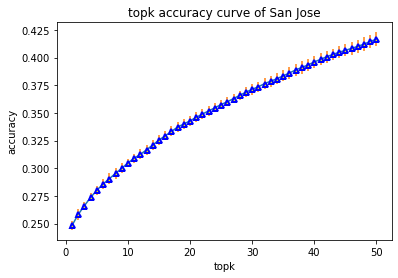

In [58]:
#nfolder test 
nfold = 10
K = 50
topk_acc = []
for n in range(nfold):
    tr,tt = splitdat(pdcl)
    tr['duns_number']=tr['duns_number'].astype(int)
    proc_pdc = comp_dat_process(pdc)
    print(len(proc_pdc))
    # proc_pdc.head()
    trX,trY,ttX,ttY = comp_transpd2np(proc_pdc,tr,tt)
    normalize_dat(trX,ttX,cols=5)
    distQR = euclidean_distances(ttX,trX)
    print(distQR.shape)
    
    topk_acc.append(calc_topk_acc_cat_all(-distQR,ttY[:,0],trY[:,0],k=K))
    
#plot    
R = np.array(topk_acc)
mR = R.mean(axis=0)
stdR = R.std(axis=0)

x = list(range(1,51))
y = list(mR)
stdy = list(stdR)

plt.figure()
plt.plot(x,y)
plt.errorbar(x,y,yerr=stdy,fmt='^',mfc='yellow',mec='blue',ms=5,mew=2)

plt.xlabel("topk")
plt.ylabel("accuracy")
plt.title("topk accuracy curve of San Jose")

plt.savefig('1.jpg')

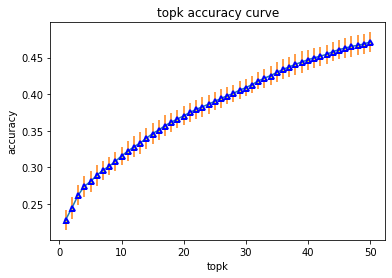